# Explaining a CIFAR-10 classifier
## Introduction
The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consits of 60,000 color images of size 32 x 32 collected by by Krizhevsky, Nair, and Hinton. The dataset has 10 classes, each class having 6,000 images which is divided in to two groups: 
- Training: 50,000 images 
- Testing: 10,000 images 


The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In [1]:
from IPython.display import clear_output
from importlib import reload

# Building up the Model 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from skimage import segmentation
import sys

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

/srv/public/.local/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


- Load the data, rescale it and split the **original training** data into training (10000 samples), validation (1000 samples ) and test set (1000 samples)
- Print the shape of your training set
- Print the number of samples in each class
- Compute the mean and standard deviation of your training and test set

In [2]:
# Code for loading the data 
# Classes (are given)
batch_size = 100
IMG_SIZE = (3, 32, 32)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
pv_std, pv_mean = (0.2470, 0.2435, 0.2616), (0.4914, 0.4822, 0.4465)
PV_FLOOR = -np.array(pv_mean) / np.array(pv_std)

random_seed = 2     # For reproducibility
torch.manual_seed(random_seed)

''' Data preparation '''
trainset = torch.load('cifar10.pt')
testset = torch.load('testset.pt')
trainset, valset = torch.utils.data.random_split(trainset, [10000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


(<matplotlib.image.AxesImage at 0x7fd6acbb2e20>, (-0.5, 341.5, 341.5, -0.5))

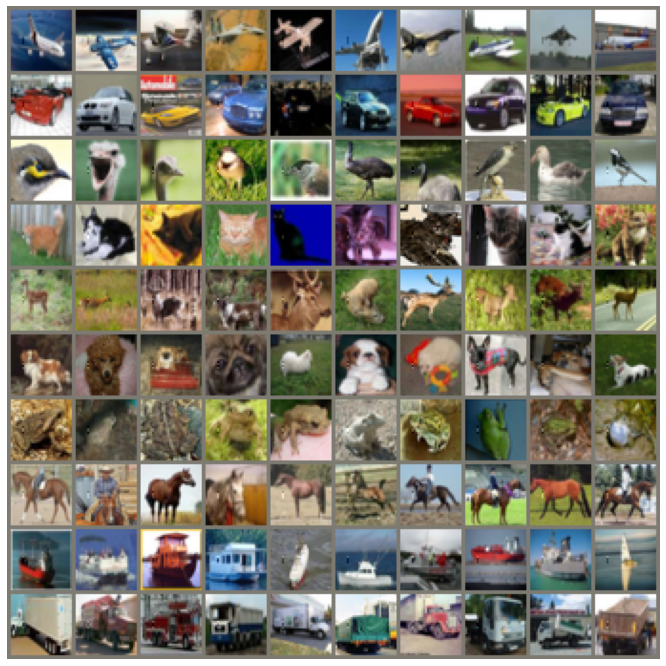

In [3]:
# Code for plotting 
buff = [[] for _ in range(10)]
# switches = [1 for _ in range(10)]
for p in trainset:
    buff[p[1]].append(p[0].unsqueeze(dim=0))
show10 = [torch.cat(l[:10]) for l in buff]
buff = [torch.cat(l) for l in buff]

def unnormalize(img, pv_mean, pv_std):
    # print(img.shape)
    img = img.permute(1,2,0)
    return (img * torch.tensor(pv_std) + torch.tensor(pv_mean)).permute(2,0,1)

show10 = torch.cat(show10)
print(show10.shape)

res = torchvision.utils.make_grid(show10, nrow=10)
res = unnormalize(res, pv_mean, pv_std).permute(1,2,0)
plt.figure(figsize=(12,12))
plt.imshow(res), plt.axis('off')

# means = [torch.mean(l, dim=0, keepdim=True) for l in buff]
# means = torch.cat(means)
# res = torchvision.utils.make_grid(means, nrow=10)
# res = unnormalize(res.permute(1,2,0), pv_mean, pv_std)
# plt.figure(figsize=(12,12))
# plt.imshow(res), plt.axis('off')

## Define and train a CNN

In [4]:
# Code for training on CIFAR-10
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn, self.opt = None, None
    
    def set_loss_fn(self, loss_fn):
        self.loss_fn = loss_fn
    
    def set_optimizer(self, opt):
        self.opt = opt

class CNN(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 2, padding=1)      # 16x16
        self.conv2 = nn.Conv2d(32, 64, 3, 2, padding=1)     # 8x8
        self.conv3 = nn.Conv2d(64, 128, 3, 2, padding=1)    # 4x4

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def get_loss(m, batch, loss_fn):
    xs, ys = batch
    codes = F.one_hot(ys, num_classes=10).type(torch.float32)
    logits = m(xs) #.cuda()
    return loss_fn(logits, codes), logits #.cuda()
    
def evaluate(m, loss_fn, dl, pbar=None):
    m.eval()
    dh = iter(dl)
    hit_count, total_count, losses = 0, 0, 0.
    with torch.no_grad():
        for batch in dh:
            loss, logits = get_loss(m, batch, loss_fn)
            losses += loss.detach().cpu()
            preds = torch.argmax(logits, dim=1).detach().cpu()
            lbls = batch[1] 
            hit_count += preds.eq(lbls.view_as(preds)).sum()
            total_count += len(lbls)
        losses /= total_count
        if pbar:
            msg = 'Avg. loss: {:.4f}, Acc.: {:>5}/{:>5} -- [{:.2f}]'.format(losses, hit_count, total_count,
                                                                             100. * hit_count / total_count)
            pbar.set_postfix_str(msg)
        return losses, hit_count/total_count


model = CNN()
loss_fn = nn.CrossEntropyLoss()
opt = optim.NAdam(model.parameters(), lr=1e-2)
model.set_loss_fn(loss_fn), model.set_optimizer(opt)

(None, None)

In [231]:
def train(m, train_dl, val_dl, num_epochs, saving_pth, verbose=False, early_stop=20):
    m.train()
    best_acc = 0.

    early_stop_count = 0

    with tqdm(total=40000*num_epochs) as pbar:
        for _ in range(num_epochs):
            for i, batch in tqdm(enumerate(iter(train_dl))):
                m.opt.zero_grad()
                loss, _ = get_loss(m, batch, m.loss_fn)
                loss.backward(), m.opt.step()

                if i % 5 == 0:
                    _, acc = evaluate(m, m.loss_fn, val_dl, pbar=pbar)
                    if acc > best_acc:
                        torch.save(m.state_dict(), saving_pth)
                        best_acc = acc
                        early_stop_count = 0
                    else:
                        early_stop_count += 1

                m.train()
                pbar.update(len(batch[1]))
                if early_stop is not None and early_stop_count >= early_stop:
                    break
            if early_stop is not None and early_stop_count >= early_stop:
                break
    m.eval()
    return m

model = train(model, trainloader, valloader, 5, 'cifar_cnn_simple.pt', early_stop=50)

100it [00:12,  8.02it/s]0000 [00:12<04:24, 720.69it/s, Avg. loss: 0.0180, Acc.:  3383/10000 -- [33.83]] 
100it [00:13,  7.54it/s]00000 [00:25<03:43, 806.07it/s, Avg. loss: 0.0173, Acc.:  3746/10000 -- [37.46]]
100it [00:10,  9.14it/s]00000 [00:36<04:44, 598.27it/s, Avg. loss: 0.0168, Acc.:  3709/10000 -- [37.09]] 
100it [00:13,  7.19it/s]00000 [00:50<04:04, 655.42it/s, Avg. loss: 0.0119, Acc.:  5686/10000 -- [56.86]]
100it [00:10,  9.76it/s]00000 [01:01<03:01, 830.79it/s, Avg. loss: 0.0014, Acc.:  9633/10000 -- [96.33]] 
 25%|██▌       | 50000/200000 [01:01<03:03, 817.50it/s, Avg. loss: 0.0014, Acc.:  9633/10000 -- [96.33]]


In [5]:
# Code for prediction
model = CNN()
model.load_state_dict(torch.load('./cifar_cnn_simple.pt'))
model, model.eval() #model.cuda()

preds, lbls = [], []
for batch in iter(valloader):
    xs, ys = batch

    logits = model(xs) #.cuda()
    ys_hat = torch.argmax(logits, axis=1).detach().cpu()
    preds.append(ys_hat)
    lbls.append(ys)
preds, lbls = torch.cat(preds), torch.cat(lbls)

# Code for classification report and confusion matrix
print(classification_report(lbls, preds))
print(confusion_matrix(lbls, preds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1018
           1       0.95      0.98      0.97      1016
           2       0.97      1.00      0.98       977
           3       0.96      0.94      0.95       989
           4       0.98      0.94      0.96      1004
           5       0.99      0.97      0.98       959
           6       1.00      0.97      0.98       995
           7       0.92      0.97      0.94      1049
           8       0.99      0.98      0.98       991
           9       0.99      0.96      0.98      1002

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 978    5    9   16    3    0    1    3    3    0]
 [   5 1000    0    8    1    0    0    1    0    1]
 [   0    0  973    3    0    0    1    0    0    0]
 [  33   17    5  925    2    0    0    5    0    2]
 [   6    0    0    0  944   

# Explaining model decision through perturbation
The model performs very well on the validation set, and in fact the performance is to good to be real given the shallower structure of the classifier and the high level concept carried by the classification task. So our next step is to uncover the secret of its success.

The most straightforward idea to explain the behavior of a target model is to perturb the explicand $x$ (saying the model decision $f(x)$ is what we try to explain) by "hiding" features in $x$.
Intuitively, the removal of features that triggers higher change in term of the prediction outcome $f(x)$ is considered more important.

But, how do we hide a feature? It is known that common ML models do not take inputs with absent feature values.

$\rightarrow$ A walkaround solution: defining the absence with some default value

In [70]:
def perturb(x, grid_scale_exp=0, num_samples=100, v_default=0):
    """
    The perturb function takes an input x and create a synthetic set with labels assigned by the target model.
    """
    w = IMG_SIZE[-1]
    scaling_ratio = 2**grid_scale_exp
    init_w = int(w / scaling_ratio)
    vs = torch.ones_like(x) * v_default

    ptr = 0
    masks_final = []
    while ptr < num_samples:
        batch_num = min(batch_size, num_samples-ptr)
        noises = torch.randint(2, (batch_num, init_w, init_w, 1))
        # noises = np.repeat(noises, 2, axis=1)
        # noises = np.repeat(noises, 2, axis=2)
        noises = noises.repeat(1, 1, scaling_ratio, scaling_ratio)
        noises = noises.reshape(batch_num, 1, w, w)
        masks_final.append(noises)
        ptr += batch_size
    masks_final = torch.concat(masks_final)
    zs = x * masks_final + (1-masks_final) * vs
    return zs, masks_final


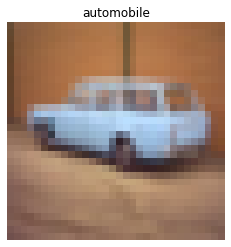

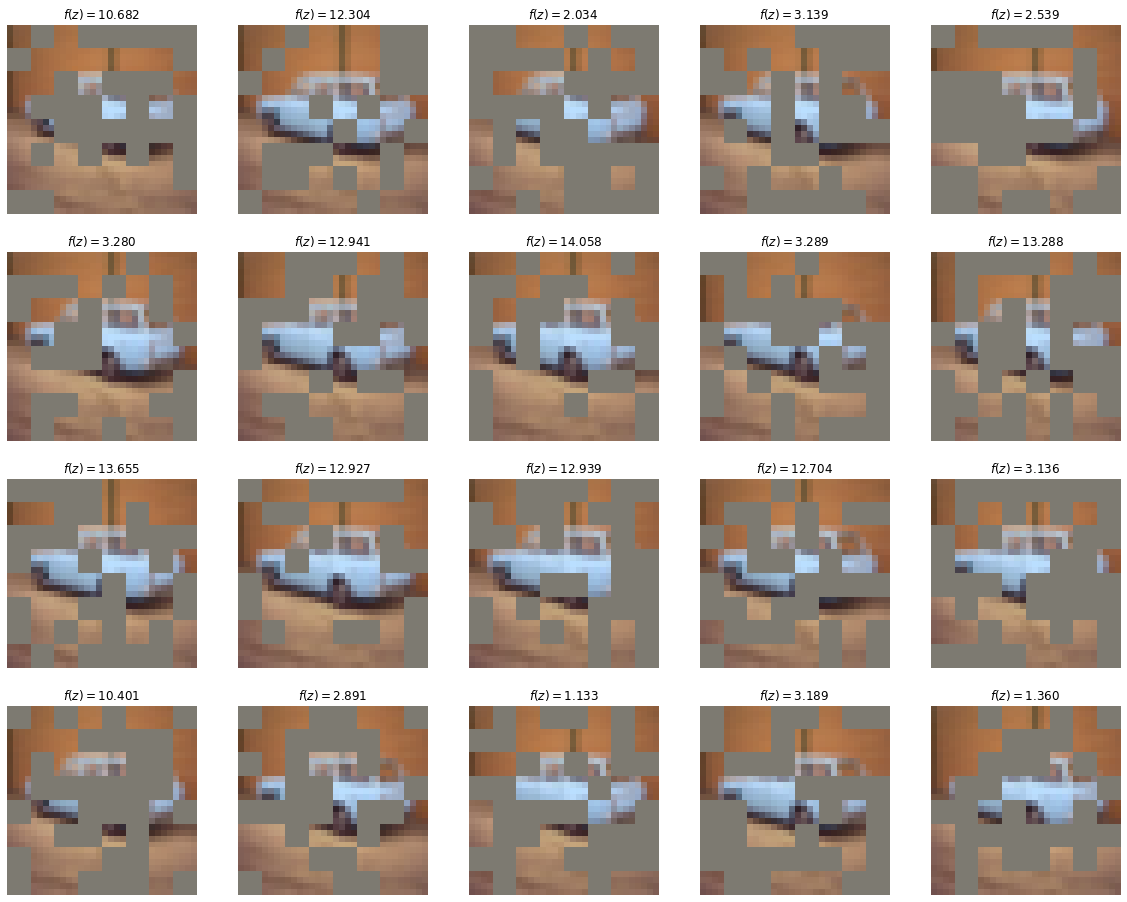

In [71]:
explicand = xs[5]
img2show = unnormalize(explicand, pv_mean, pv_std).permute(1,2,0)

num_samples = 100
zs, masks = perturb(explicand, 2, num_samples)
y = model(explicand.unsqueeze(0)).argmax()
plt.imshow(img2show)
plt.title(classes[y]), plt.axis('off')

y_probs = model(zs)[:, y].detach().cpu()
_, axs = plt.subplots(4, 5, figsize=(20, 16))
axs = axs.flatten()
for i, z in enumerate(zs[:20]):
    z2show = unnormalize(z, pv_mean, pv_std).permute(1,2,0)
    axs[i].imshow(z2show), axs[i].axis('off')
    axs[i].set_title(r'$f(z)={:.3f}$'.format(y_probs[i]))

Now we summarize the information in the observations with a linear regressor to determine the most contributing features.

(<matplotlib.image.AxesImage at 0x7fd6529142b0>, (-0.5, 31.5, 31.5, -0.5))

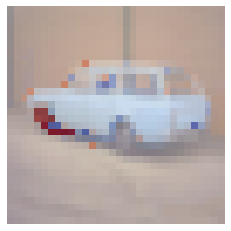

In [75]:
def train_regressor(xs, ys, kernel_width=1.):
    local_predictor = Ridge(alpha=1, fit_intercept=True, random_state=1)
    local_predictor.fit(xs, ys)
    return local_predictor
masks = masks.reshape(num_samples, -1)
surrogate = train_regressor(masks, y_probs)

coef = surrogate.coef_.reshape(IMG_SIZE[-2], IMG_SIZE[-1])
plt.imshow(img2show)
plt.imshow(coef, cmap='coolwarm', alpha=0.5), plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


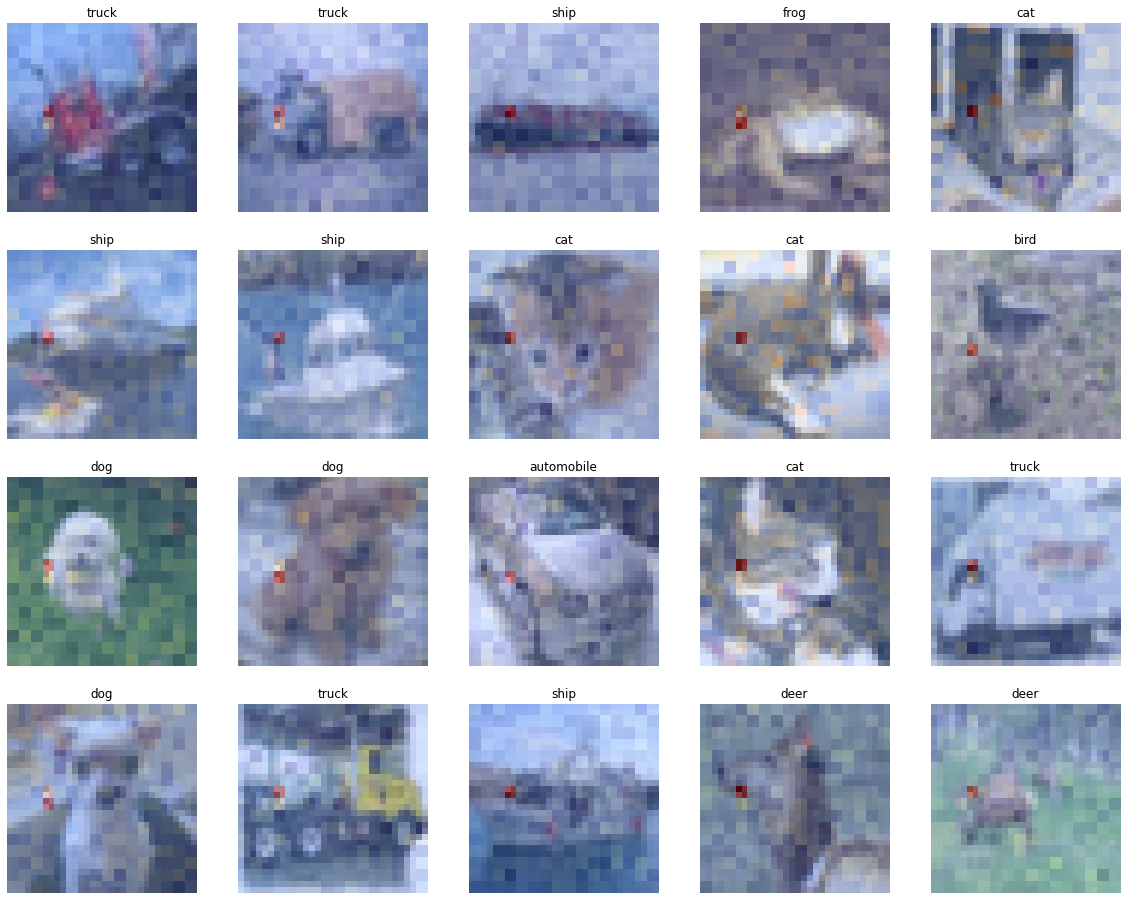

In [76]:
def explain(model, x, num_samples=100):
    num_samples = 100
    zs, masks = perturb(x, 1, num_samples)
    y = model(x.unsqueeze(0)).argmax()
    y_probs = model(zs)[:, y].detach().cpu()
    masks = masks.reshape(num_samples, -1)
    surrogate = train_regressor(masks, y_probs)
    return surrogate.coef_.reshape(IMG_SIZE[-2], IMG_SIZE[-1])

_, axs = plt.subplots(4, 5, figsize=(20, 16))
axs = axs.flatten()
for i, x in enumerate(xs[20:40]):
    img2show = unnormalize(x, pv_mean, pv_std).permute(1,2,0)
    sal = explain(model, x, 5000)
    y = model(x.unsqueeze(0)).argmax()
    axs[i].imshow(img2show), axs[i].axis('off'), axs[i].set_title(classes[y])
    axs[i].imshow(sal, cmap='coolwarm', alpha=0.4)

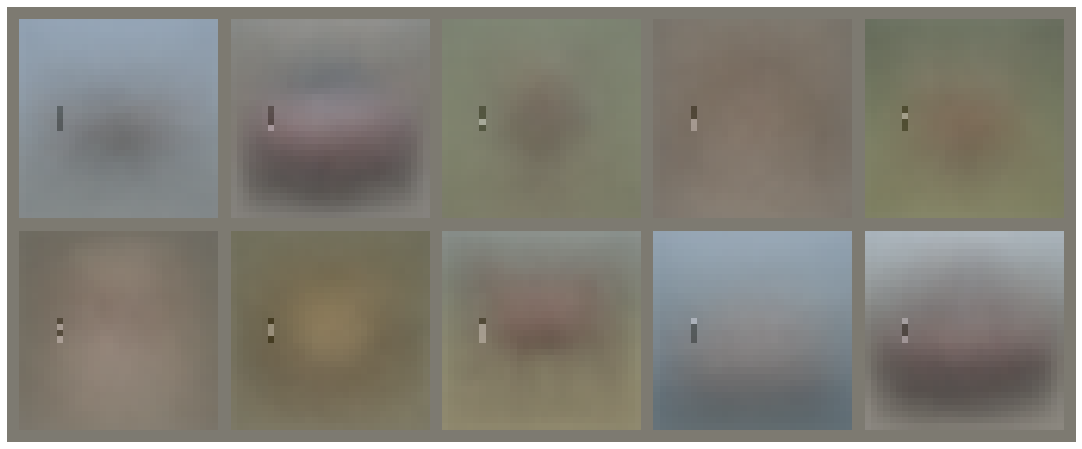

In [11]:
# code for mean class image visualization
buff = [[] for _ in range(10)]
# switches = [1 for _ in range(10)]
for p in trainset:
    buff[p[1]].append(p[0].unsqueeze(dim=0))
buff = [torch.cat(l) for l in buff]

means = [torch.mean(l, dim=0, keepdim=True) for l in buff]
means = torch.cat(means)
res = torchvision.utils.make_grid(means, nrow=5)
res = unnormalize(res, pv_mean, pv_std).permute(1,2,0)
plt.figure(figsize=(20,8))
_ = plt.imshow(res), plt.axis('off')

In [12]:
# Code for prediction
preds, lbls = [], []
for batch in iter(testloader):
    xs, ys = batch

    logits = model(xs) #.cuda()
    ys_hat = torch.argmax(logits, axis=1).detach().cpu()
    preds.append(ys_hat)
    lbls.append(ys)
preds, lbls = torch.cat(preds), torch.cat(lbls)

# Code for classification report and confusion matrix
print(classification_report(lbls, preds))
print(confusion_matrix(lbls, preds))

              precision    recall  f1-score   support

           0       0.12      0.88      0.21      1000
           1       0.42      0.12      0.19      1000
           2       0.12      0.00      0.01      1000
           3       0.16      0.32      0.21      1000
           4       0.15      0.01      0.01      1000
           5       0.00      0.00      0.00      1000
           6       0.38      0.01      0.01      1000
           7       0.16      0.03      0.04      1000
           8       0.08      0.00      0.00      1000
           9       0.10      0.00      0.01      1000

    accuracy                           0.14     10000
   macro avg       0.17      0.14      0.07     10000
weighted avg       0.17      0.14      0.07     10000

[[881  27   3  63   2   0   0  14   4   6]
 [686 119   5 159   3   0   0  14   2  12]
 [784  14   3 177   6   0   2  13   1   0]
 [642   6   3 324   5   0   1  13   4   2]
 [718   5   2 245   7   0   2  18   1   2]
 [681   7   1 289   3   0 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


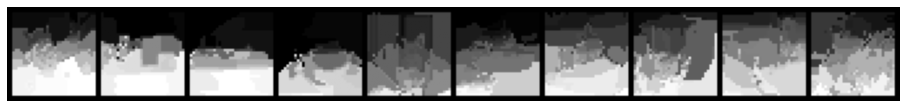

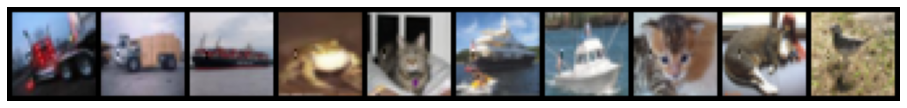

In [81]:
masks, imgs = [], []
for i, x in enumerate(xs[20:30]):
    param_dict = dict(kernel_size=2, max_dist=5, ratio=0.2, random_seed=1)
    mask = segmentation.quickshift(x.permute(1,2,0), **param_dict)
    mask2show = torch.tensor(mask/np.max(mask)).unsqueeze(0)
    mask2show = torch.cat(3 * (mask2show,))
    masks.append(mask2show.unsqueeze(0))
    
    x = unnormalize(x, pv_mean, pv_std)
    imgs.append(x.unsqueeze(0))

plt.figure(figsize=(16,3)), plt.tight_layout(), plt.axis('off')
masks = torch.cat(masks)
res = torchvision.utils.make_grid(masks, nrow=10)
plt.imshow(res.permute(1,2,0))

plt.figure(figsize=(16,3)), plt.tight_layout(), plt.axis('off')
imgs = torch.cat(imgs)
res = torchvision.utils.make_grid(imgs, nrow=10)
plt.imshow(res.permute(1,2,0))

In [65]:
def perturb_superpixels(x, segmented, num_samples=100, v_default=0):
    """
    The perturb function takes an input x and create a synthetic set with labels assigned by the target model.
    """
    num_clusters = segmented.max() + 1
    vs = np.ones_like(x) * v_default
    masks_final = []
    for _ in range(num_samples):
        noises = np.random.choice([0, 1], num_clusters)
        mask = segmented.copy()
        for i, v in enumerate(noises):
            locs = np.where(segmented==i)
            mask[locs[0], locs[1]] = v
        masks_final.append(np.expand_dims(mask, axis=(0,1)))
    masks_final = np.concatenate(masks_final)
    zs = x * masks_final + (1-masks_final) * vs
    return zs.type(torch.float32), masks_final

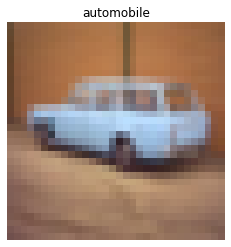

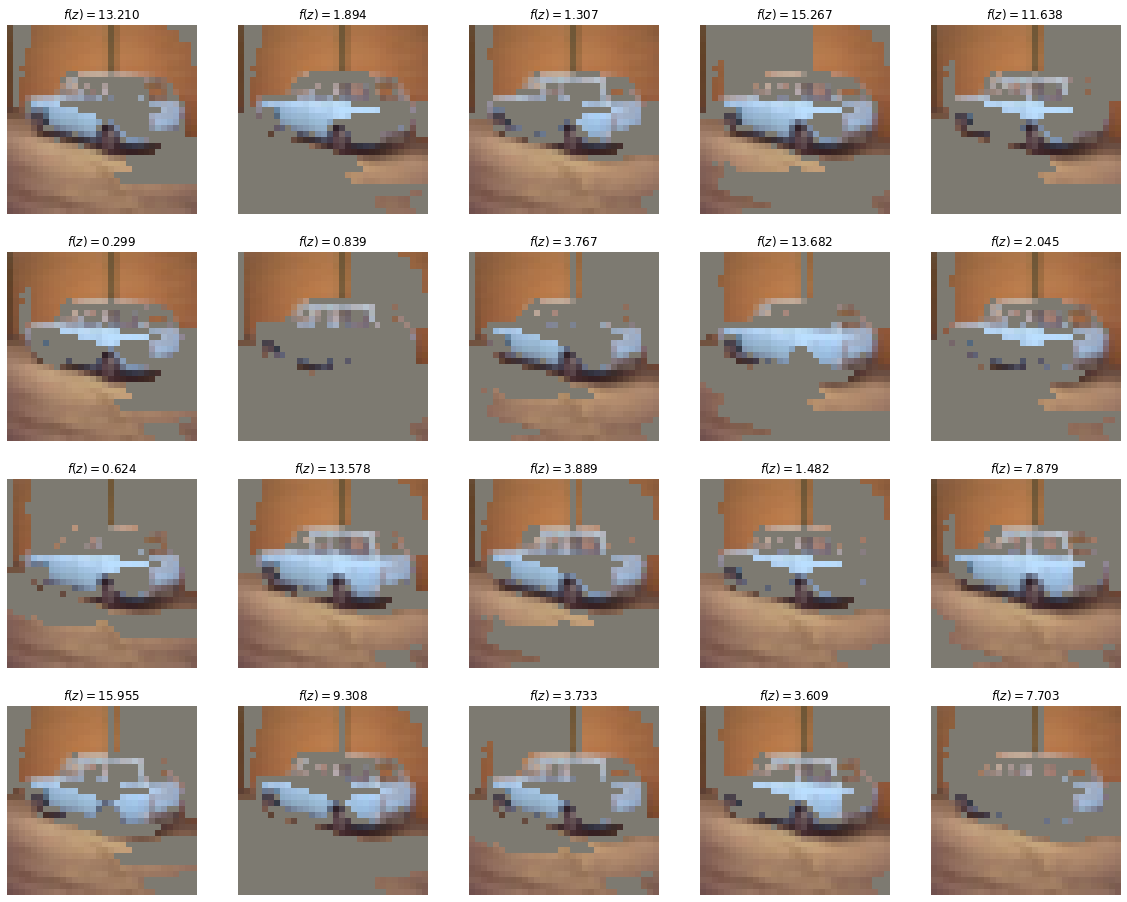

In [73]:
param_dict = dict(kernel_size=2, max_dist=5, ratio=0.2, random_seed=1)

explicand = xs[5]
img2show = unnormalize(explicand, pv_mean, pv_std).permute(1,2,0)
segmented = segmentation.quickshift(explicand.permute(1,2,0), **param_dict)

num_samples = 100
zs, masks = perturb_superpixels(explicand, segmented, num_samples)
y = model(explicand.unsqueeze(0)).argmax()
plt.imshow(img2show)
plt.title(classes[y]), plt.axis('off')

y_probs = model(zs)[:, y].detach().cpu()
_, axs = plt.subplots(4, 5, figsize=(20, 16))
axs = axs.flatten()
for i, z in enumerate(zs[:20]):
    z2show = unnormalize(z, pv_mean, pv_std).permute(1,2,0)
    axs[i].imshow(z2show), axs[i].axis('off')
    axs[i].set_title(r'$f(z)={:.3f}$'.format(y_probs[i]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


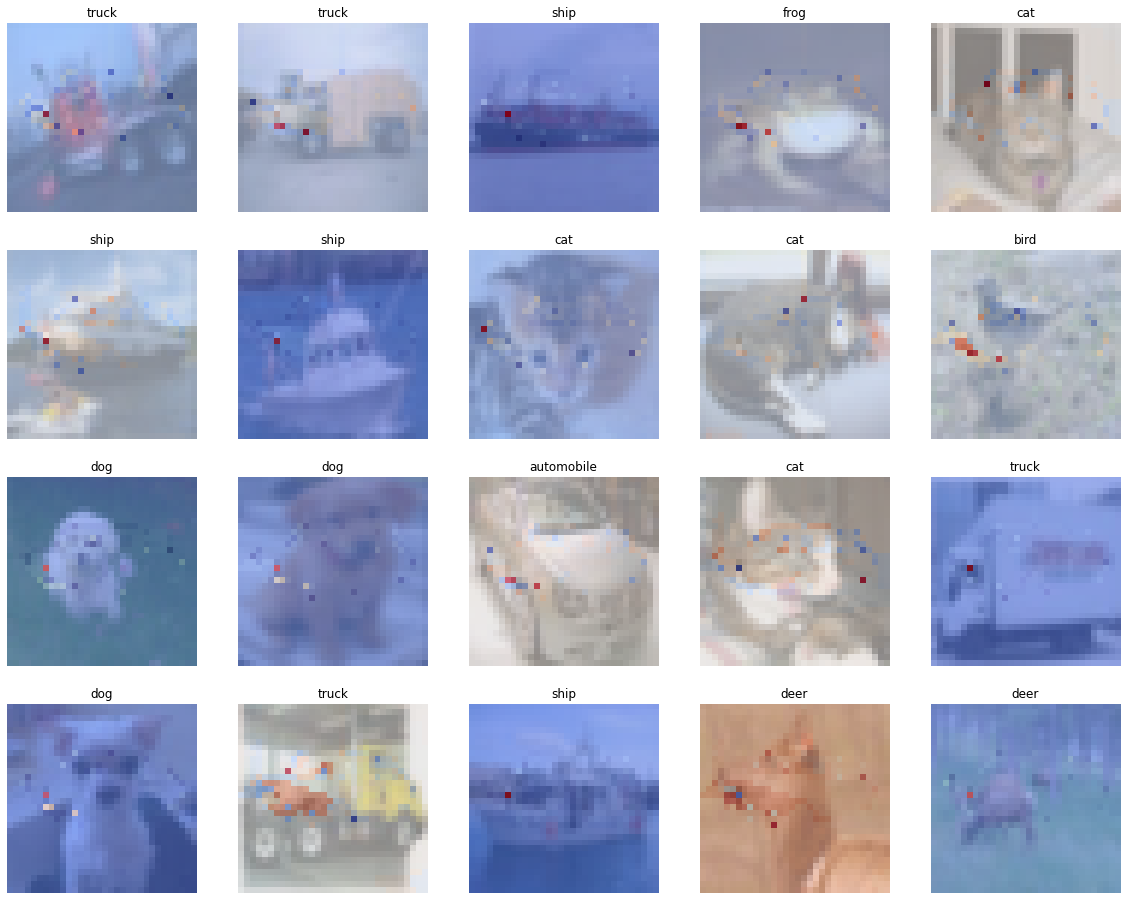

In [80]:
def explain_superpixel(model, x, num_samples=100):
    num_samples = 100
    segmented = segmentation.quickshift(explicand.permute(1,2,0), **param_dict)
    zs, masks = perturb_superpixels(x, segmented, num_samples)
    y = model(x.unsqueeze(0)).argmax()
    y_probs = model(zs)[:, y].detach().cpu()
    masks = masks.reshape(num_samples, -1)
    surrogate = train_regressor(masks, y_probs)
    return surrogate.coef_.reshape(IMG_SIZE[-2], IMG_SIZE[-1])

_, axs = plt.subplots(4, 5, figsize=(20, 16))
axs = axs.flatten()
for i, x in enumerate(xs[20:40]):
    img2show = unnormalize(x, pv_mean, pv_std).permute(1,2,0)
    sal = explain_superpixel(model, x, 5000)
    y = model(x.unsqueeze(0)).argmax()
    axs[i].imshow(img2show), axs[i].axis('off'), axs[i].set_title(classes[y])
    axs[i].imshow(sal, cmap='coolwarm', alpha=0.6)

# Explaining decision with gradients

In [13]:
def get_device(m):
    return next(m.parameters()).device

# Code for vanilla gradient
class GradBased:
    def __init__(self):
        self.model = None

    def set_env(self, m):
        self.model = m

    def _get_grad(self, img, lbl):
        img = img.clone().detach().requires_grad_(True)
        output = self.model(img)[:, lbl]
        return torch.autograd.grad(output, img)[0].cpu()
    
class VanillaGrad(GradBased):
    def __init__(self):
        super(VanillaGrad, self).__init__()
    
    def explain(self, img):
        device = get_device(self.model)
        lbl = np.argmax(self.model(img.to(device))[0].detach().cpu())
        grad = self._get_grad(img.to(device), lbl)[0]
        return grad

expl_vg = VanillaGrad()
expl_vg.set_env(model)
handler = iter(trainloader)

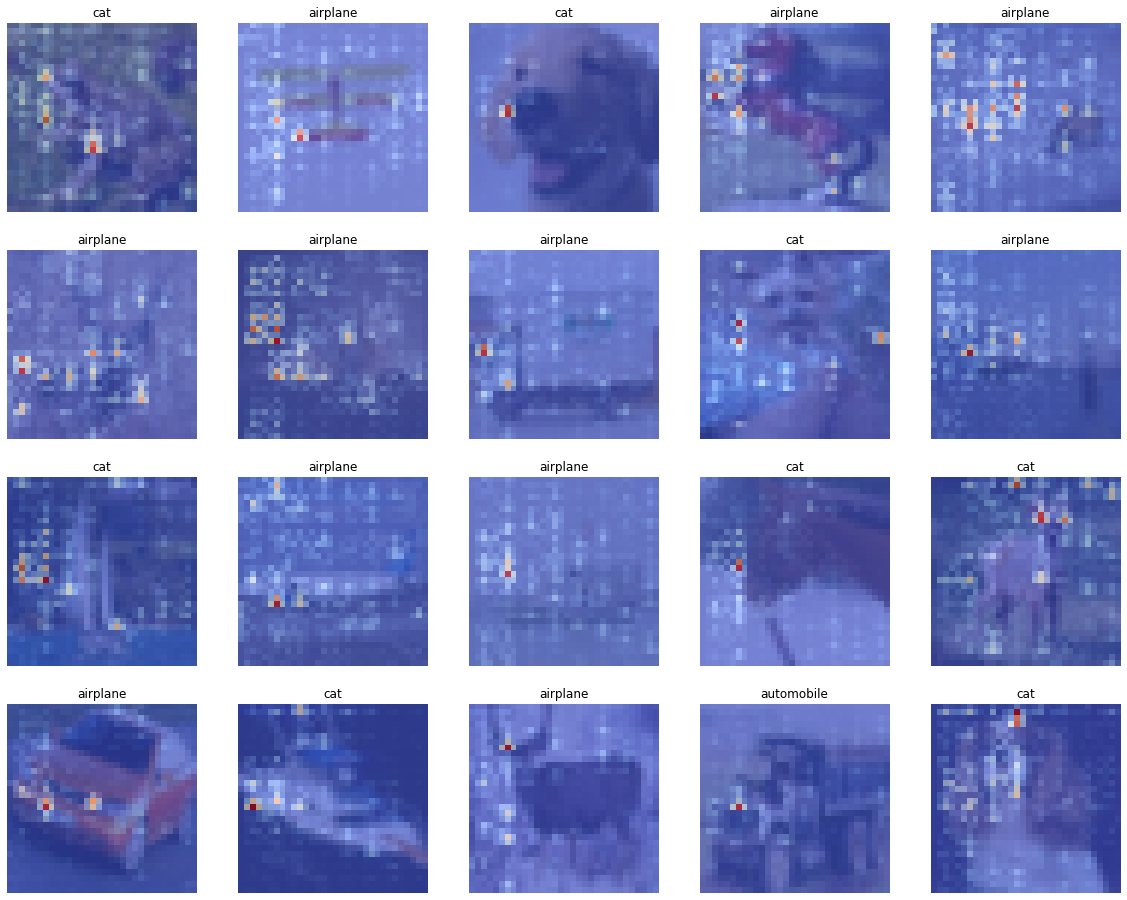

In [14]:
# Tensor having shape B x C x W x H
img, lbl = next(handler)

_, axs = plt.subplots(4, 5, figsize=(20, 16))
axs = axs.flatten()
for i, x in enumerate(xs[20:40]):
    img2show = unnormalize(x, pv_mean, pv_std).permute(1,2,0)
    sal = expl_vg.explain(x.unsqueeze(0))
    sal = torch.abs(torch.mean(sal, dim=0))
    y = model(x.unsqueeze(0)).argmax()
    axs[i].imshow(img2show), axs[i].axis('off'), axs[i].set_title(classes[y])
    axs[i].imshow(sal, cmap='coolwarm', alpha=0.7)
